In [1]:
from h3 import h3
import pandas as pd
import shapely
import geojson
import geopandas as gpd
import math
from pyproj import Geod
import matplotlib.pyplot as plt

In [2]:
pd.options.display.float_format = '{:.4f}'.format

# Part 1: Prepare Avg distance calculation

## Prepare Data

**Read-In LOR shapes Charlottenburg-Wilmersdorf**

In [3]:
df_lor = pd.DataFrame(gpd.read_file('lor_cw.geojson'))

**Convert geometry column to geojson column**

In [4]:
def to_geojson(geometry):
    
    points = str(list(geometry)[0]).replace('(','').replace(')','').replace('POLYGON ','').split(', ')
    
    coordinates = list()
    
    for string in points:
        
        lat_lon = string.split(' ')
        lat_lon[0] = float(lat_lon[0])
        lat_lon[1] = float(lat_lon[1])
        
        coordinates.append(lat_lon)
        
    geojson= list([coordinates])
    return {"type": "Polygon", "coordinates": geojson}

df_lor['geojson'] = df_lor.geometry.apply(lambda x: to_geojson(x))
df_lor.head(3)

,gml_id,spatial_name,spatial_alias,spatial_type,PLRNAME,BZRNAME,PGRNAME,BEZNAME,DATUM,SHAPE_AREA,geometry,geojson
0,re_planungsraum.04010101,04010101,Jungfernheide,Polygon,Jungfernheide,Charlottenburg Nord,CW 1,Charlottenburg-Wilmersdorf,2006-06-14T00:00:00,3066535.9995,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...","{'type': 'Polygon', 'coordinates': [[[13.30145..."
1,re_planungsraum.04020209,04020209,Eichkamp,Polygon,Eichkamp,Heerstrasse,CW 2,Charlottenburg-Wilmersdorf,2006-06-14T00:00:00,1606439.6260,"MULTIPOLYGON (((13.25413 52.50521, 13.25390 52...","{'type': 'Polygon', 'coordinates': [[[13.25413..."
2,re_planungsraum.04020310,04020310,Park Ruhwald,Polygon,Park Ruhwald,Westend,CW 2,Charlottenburg-Wilmersdorf,2006-06-14T00:00:00,2043077.3867,"MULTIPOLYGON (((13.27965 52.53028, 13.27985 52...","{'type': 'Polygon', 'coordinates': [[[13.27965..."


**Read-In LOR structural data Charlottenburg Wilmersdorf**

In [5]:
df_lor_data = pd.read_csv('EWR201812E_Matrix.csv', sep=';', dtype={'RAUMID': str})
df_lor_data.head(3)

,ZEIT,RAUMID,BEZ,PGR,BZR,PLR,STADTRAUM,E_E,E_EM,E_EW,...,E_E95_110,E_EU1,E_E1U6,E_E6U15,E_E15U18,E_E18U25,E_E25U55,E_E55U65,E_E65U80,E_E80U110
0,201812,01011101,1,1,11,1,1,3384,1751,1633,...,6,27,151,120,38,322,1616,383,542,185
1,201812,01011102,1,1,11,2,1,196,127,69,...,0,0,3,3,3,12,115,38,22,0
2,201812,01011103,1,1,11,3,1,5038,2698,2340,...,21,48,195,325,109,412,2281,742,694,232


**Read-In store locations**

In [6]:
df_store_loc = gpd.read_file('store_locations.geojson')
df_store_loc.head(3)

,Filialname,Kunden pro tag,geometry
0,Kracauerplatz,1950,POINT (13.29640 52.50189)
1,Kaiserin-Augusta-Allee,1000,POINT (13.31061 52.52574)
2,Lietzenburger Str,1450,POINT (13.32483 52.50000)


## Merge Data

**Merge CH shapes with CH structural data**

In [7]:
df_lor = df_lor.merge(df_lor_data[['RAUMID','E_E']], left_on='spatial_name', right_on='RAUMID')

**Select, order and rename columns**

In [8]:
df_lor = df_lor[['spatial_name','spatial_alias', 'SHAPE_AREA', 'E_E', 'geometry', 'geojson']]

In [9]:
df_lor.rename(columns={"spatial_name": "neighbourhood_id", 
                       "spatial_alias": "neighbourhood_name", 
                       "SHAPE_AREA": "area",
                       "E_E": "pop"
                      }, inplace=True)

## Find hexagons of level 9 in LOR

In [10]:
h3.hex_area(8)

0.7373276

**Find all level 9 hexagons that intersect the LORs**

In [11]:
df_lor['hex'] = df_lor.geojson.apply(lambda x: list(h3.polyfill(x, 9)))

**Determine number of hexagons per LOR**

In [12]:
df_lor['hex_count'] = df_lor.hex.apply(lambda x: len(x))

In [13]:
df_lor.head(3)

,neighbourhood_id,neighbourhood_name,area,pop,geometry,geojson,hex,hex_count
0,04010101,Jungfernheide,3066535.9995,10785,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...","{'type': 'Polygon', 'coordinates': [[[13.30145...","[8963a3d030fffff, 8963a3d0267ffff, 8963a3d037b...",62
1,04020209,Eichkamp,1606439.6260,3214,"MULTIPOLYGON (((13.25413 52.50521, 13.25390 52...","{'type': 'Polygon', 'coordinates': [[[13.25413...","[8963a3d1307ffff, 8963a3d1313ffff, 8963a3d13c7...",33
2,04020310,Park Ruhwald,2043077.3867,616,"MULTIPOLYGON (((13.27965 52.53028, 13.27985 52...","{'type': 'Polygon', 'coordinates': [[[13.27965...","[8963a3d1eafffff, 8963a3d1e37ffff, 8963a3d1ccf...",37


## Calculate pre-measures

**Calculate population density**

In [14]:
df_lor['pop_den'] = df_lor['pop']/ (df_lor['area']/1000)

**Calculate scale factor 'pop share' based on population distribution**

In [15]:
df_lor['pop_sum'] = df_lor['pop'].sum()

In [16]:
df_lor['pop_share'] = df_lor['pop'] / df_lor['pop_sum']

In [17]:
df_lor.head(3)

,neighbourhood_id,neighbourhood_name,area,pop,geometry,geojson,hex,hex_count,pop_den,pop_sum,pop_share
0,04010101,Jungfernheide,3066535.9995,10785,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...","{'type': 'Polygon', 'coordinates': [[[13.30145...","[8963a3d030fffff, 8963a3d0267ffff, 8963a3d037b...",62,3.5170,322774,0.0334
1,04020209,Eichkamp,1606439.6260,3214,"MULTIPOLYGON (((13.25413 52.50521, 13.25390 52...","{'type': 'Polygon', 'coordinates': [[[13.25413...","[8963a3d1307ffff, 8963a3d1313ffff, 8963a3d13c7...",33,2.0007,322774,0.0100
2,04020310,Park Ruhwald,2043077.3867,616,"MULTIPOLYGON (((13.27965 52.53028, 13.27985 52...","{'type': 'Polygon', 'coordinates': [[[13.27965...","[8963a3d1eafffff, 8963a3d1e37ffff, 8963a3d1ccf...",37,0.3015,322774,0.0019


## Create list based on hexagons

**Explode list based on hex column**

In [18]:
df_hex = df_lor.explode('hex').reset_index(drop=True)

In [19]:
df_hex.neighbourhood_id.count()

1112

**Re-factor pop_share per hexagon based on assumption of equal pop distribution within lor**

In [20]:
df_hex['pop_share'] = df_hex['pop_share']/ df_hex['hex_count']

**Select and order columns**

In [21]:
df_hex = df_hex[['hex', 'neighbourhood_id', 'neighbourhood_name', 'pop_den', 'pop_share', 'geometry']]

In [22]:
df_hex.head(3)

,hex,neighbourhood_id,neighbourhood_name,pop_den,pop_share,geometry
0,8963a3d030fffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52..."
1,8963a3d0267ffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52..."
2,8963a3d037bffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52..."


## Calculate avg distance starting from one hex to all other hex

**Get coordinates of hex center points**

In [23]:
def get_centroid(x):
    
    if pd.isna(x.hex):
        
        # For those which contain no hexagons (because too small), take centroid of multipolygon
        return [x.geometry.centroid.coords[0][0],x.geometry.centroid.coords[0][1]]
    
    else:
        
        return h3.h3_to_geo(x.hex)


df_hex[['geo_center_lon','geo_center_lat']] = pd.DataFrame(df_hex.apply(lambda x: get_centroid(x), axis=1).tolist(), index=df_hex.index)

**Build all combinations via merge**

In [24]:
df_hex['mg'] = 1
df_dist = df_hex.merge(df_hex[['hex', 'geo_center_lat', 'geo_center_lon', 'mg']], on='mg')
df_dist = df_dist[['hex_x', 'hex_y', 'geo_center_lat_x', 'geo_center_lon_x', 'geo_center_lat_y', 'geo_center_lon_y']]
df_dist.head(3)

,hex_x,hex_y,geo_center_lat_x,geo_center_lon_x,geo_center_lat_y,geo_center_lon_y
0,8963a3d030fffff,8963a3d030fffff,52.5466,13.2887,52.5466,13.2887
1,8963a3d030fffff,8963a3d0267ffff,52.5466,13.2887,52.5296,13.2864
2,8963a3d030fffff,8963a3d037bffff,52.5466,13.2887,52.5426,13.2843


In [25]:
df_dist = df_dist[df_dist.hex_x != df_dist.hex_y]

**Calculate all distances**

In [26]:
wgs84_geod = Geod(ellps='WGS84')

def distance(lat1,lon1,lat2,lon2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2)
    return dist

df_dist['geo_dist'] = df_dist.apply(lambda x: distance(x.geo_center_lat_x, x.geo_center_lon_x, x.geo_center_lat_y, x.geo_center_lon_y), axis=1)
df_dist.head(3)

,hex_x,hex_y,geo_center_lat_x,geo_center_lon_x,geo_center_lat_y,geo_center_lon_y,geo_dist
1,8963a3d030fffff,8963a3d0267ffff,52.5466,13.2887,52.5296,13.2864,1900.7257
2,8963a3d030fffff,8963a3d037bffff,52.5466,13.2887,52.5426,13.2843,535.3188
3,8963a3d030fffff,8963a3d1ddbffff,52.5466,13.2887,52.5419,13.2768,964.5673


**Calculate avg distance per hexagon**

In [27]:
df_dist = df_dist.groupby(['hex_x']).agg({'geo_dist': 'mean'}).reset_index()

In [28]:
df_dist.head(3)

,hex_x,geo_dist
0,8963a2a4903ffff,4453.3257
1,8963a2a4907ffff,4269.4009
2,8963a2a490bffff,4534.3631


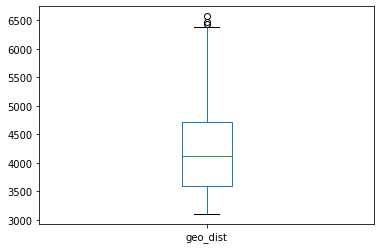

In [29]:
plt.figure()
df_dist.geo_dist.plot.box()

**Merge to hex table**

In [30]:
df_hex = df_hex.merge(df_dist, left_on='hex', right_on='hex_x').drop(columns=['mg', 'hex_x'])
df_hex.rename(columns={'geo_dist': 'geo_dist_avg'}, inplace=True)

In [31]:
df_hex.head(3)

,hex,neighbourhood_id,neighbourhood_name,pop_den,pop_share,geometry,geo_center_lon,geo_center_lat,geo_dist_avg
0,8963a3d030fffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2887,52.5466,6039.0177
1,8963a3d0267ffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2864,52.5296,4500.2728
2,8963a3d037bffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2843,52.5426,5619.8398


**Assume factor 1.3 for street distance from beeline distance**

In [32]:
beeline_dist_factor = 1.3

In [33]:
df_hex['street_dist_avg'] = beeline_dist_factor * df_hex['geo_dist_avg']

In [34]:
df_hex.head(3)

,hex,neighbourhood_id,neighbourhood_name,pop_den,pop_share,geometry,geo_center_lon,geo_center_lat,geo_dist_avg,street_dist_avg
0,8963a3d030fffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2887,52.5466,6039.0177,7850.7230
1,8963a3d0267ffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2864,52.5296,4500.2728,5850.3546
2,8963a3d037bffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2843,52.5426,5619.8398,7305.7917


# Part 2: Calculate Min Distance and Avg Distance

**Function for minimal distance**

In [35]:
def min_distance(orders):
    
    area = 64.72
    return 2*(math.sqrt((area/orders)/(2*math.sqrt(3))))

In [41]:
min_distance(4200)

0.1333918492226007

**Function for avg distance**

In [ ]:
def avg_distance(orders):
    
    con_gesamt = math.pow(orders,2)-orders
    df_hex['orders'] = orders * df_hex['pop_share']   
    df_hex['hex_con_inside'] = df_hex.apply(lambda x: math.pow(x.orders, 2)-x.orders, axis=1)
    df_hex['hex_con_out'] = con_gesamt - df_hex['hex_con_inside']
    df_hex['street_dist_avg_rescaled'] = (df_hex['hex_con_out'] * df_hex['street_dist_avg'])/con_gesamt
    
    avg_distance = df_hex['street_dist_avg_rescaled'].mean()
    
    df_hex.drop(columns=['orders', 'hex_con_inside', 'hex_con_out', 'street_dist_avg_rescaled'])
    
    return avg_distance

In [36]:
orders = 1000

In [37]:
con_gesamt = math.pow(orders,2)-orders

In [38]:
df_hex['orders'] = orders * df_hex['pop_share']
df_hex.head(3)

,hex,neighbourhood_id,neighbourhood_name,pop_den,pop_share,geometry,geo_center_lon,geo_center_lat,geo_dist_avg,street_dist_avg,orders
0,8963a3d03cfffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2922,52.5408,5520.5740,7176.7462,0.5389
1,8963a3d0343ffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2873,52.5394,5341.1303,6943.4694,0.5389
2,8963a3d038fffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2961,52.5474,6208.0751,8070.4976,0.5389


In [39]:
df_hex['hex_con_inside'] = df_hex.apply(lambda x: math.pow(x.orders, 2)-x.orders, axis=1)
df_hex.head(3)

,hex,neighbourhood_id,neighbourhood_name,pop_den,pop_share,geometry,geo_center_lon,geo_center_lat,geo_dist_avg,street_dist_avg,orders,hex_con_inside
0,8963a3d03cfffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2922,52.5408,5520.5740,7176.7462,0.5389,-0.2485
1,8963a3d0343ffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2873,52.5394,5341.1303,6943.4694,0.5389,-0.2485
2,8963a3d038fffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2961,52.5474,6208.0751,8070.4976,0.5389,-0.2485


In [40]:
df_hex['hex_con_out'] = con_gesamt - df_hex['hex_con_inside']
df_hex.head(3)

,hex,neighbourhood_id,neighbourhood_name,pop_den,pop_share,geometry,geo_center_lon,geo_center_lat,geo_dist_avg,street_dist_avg,orders,hex_con_inside,hex_con_out
0,8963a3d03cfffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2922,52.5408,5520.5740,7176.7462,0.5389,-0.2485,999000.2485
1,8963a3d0343ffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2873,52.5394,5341.1303,6943.4694,0.5389,-0.2485,999000.2485
2,8963a3d038fffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2961,52.5474,6208.0751,8070.4976,0.5389,-0.2485,999000.2485


In [41]:
df_hex['street_dist_avg_rescaled'] = (df_hex['hex_con_out'] * df_hex['street_dist_avg'])/con_gesamt
df_hex.head(3)

,hex,neighbourhood_id,neighbourhood_name,pop_den,pop_share,geometry,geo_center_lon,geo_center_lat,geo_dist_avg,street_dist_avg,orders,hex_con_inside,hex_con_out,street_dist_avg_rescaled
0,8963a3d03cfffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2922,52.5408,5520.5740,7176.7462,0.5389,-0.2485,999000.2485,7176.7480
1,8963a3d0343ffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2873,52.5394,5341.1303,6943.4694,0.5389,-0.2485,999000.2485,6943.4711
2,8963a3d038fffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2961,52.5474,6208.0751,8070.4976,0.5389,-0.2485,999000.2485,8070.4996


In [42]:
avg_distance = df_hex['street_dist_avg_rescaled'].mean()
avg_distance

5509.213119770549

In [43]:
df_hex.drop(columns=['orders', 'hex_con_inside', 'hex_con_out', 'street_dist_avg_rescaled'])

,hex,neighbourhood_id,neighbourhood_name,pop_den,pop_share,geometry,geo_center_lon,geo_center_lat,geo_dist_avg,street_dist_avg
0,8963a3d03cfffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2922,52.5408,5520.5740,7176.7462
1,8963a3d0343ffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2873,52.5394,5341.1303,6943.4694
2,8963a3d038fffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2961,52.5474,6208.0751,8070.4976
3,8963a3d1d9bffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2807,52.5485,6177.3076,8030.4999
4,8963a3d022fffff,04010101,Jungfernheide,3.5170,0.0005,"MULTIPOLYGON (((13.30145 52.54881, 13.30150 52...",13.2882,52.5342,4889.9297,6356.9086
...,...,...,...,...,...,...,...,...,...,...
1106,8963a3d8c4fffff,04061757,Forst Grunewald,0.0039,0.0000,"MULTIPOLYGON (((13.20292 52.50081, 13.20513 52...",13.1893,52.4744,6470.6419,8411.8345
1107,8963a3daab7ffff,04061757,Forst Grunewald,0.0039,0.0000,"MULTIPOLYGON (((13.20292 52.50081, 13.20513 52...",13.2205,52.4847,4494.3450,5842.6485
1108,8963a3dac0bffff,04061757,Forst Grunewald,0.0039,0.0000,"MULTIPOLYGON (((13.20292 52.50081, 13.20513 52...",13.2460,52.4838,3679.3392,4783.1409
1109,8963a3da80fffff,04061757,Forst Grunewald,0.0039,0.0000,"MULTIPOLYGON (((13.20292 52.50081, 13.20513 52...",13.2271,52.4907,4112.4029,5346.1238
